# LET'S GET READY TO RUMBLE!!!

In [1]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as tvtransforms
import torchvision.utils as vutils

In [2]:
# Batch size
batch_size = 64
# number of epochs
epochs = 10
# learning rate
alpha = 0.0002
# beta1
beta1 = 0.5
# beta2
beta2 = 0.999
# Z vector size
nz = 100

# Channels, H, W
img_shape = (1, 28, 28)
# Take advantage of the computer's GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
os.makedirs("data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor(), tvtransforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)

First, we need to create our loss functions. From the first paper, the discriminator loss from Algorithm 1, which we want to maximize, is:

$\mathcal{L}_d = \frac{1}{m}\sum_{i=1}^m\left(\log(D(x^{(i)})) + \log(1 - D(G(z^{(i)})))\right)$.

The generator loss, which we want to minimize, is

$\mathcal{L}_g = \frac{1}{m}\sum_{i=1}^m\log(1 - D(G(z^{(i)})))$.

Unfortunately, this generator loss function can be troublesome in practice. An alternative the authors suggest is

$\mathcal{L}_g = \frac{1}{m}\sum_{i=1}^m\log(D(G(z^{(i)})))$.

This function then needs to be maximized.

In [8]:
# Some handy functions:
# torch.mean()
# torch.log()

def discriminator_loss(D_of_real, D_of_fake):
    # TODO: implment loss for discriminator
    # What sign should be applied in order to maximize it?
    return -torch.mean( torch.log(D_of_real) + torch.log(1 - D_of_fake) )

def generator_loss(D_of_fake):
    # TODO: implment loss for generator
    # What sign should be applied in order to maximize or minimize it?
    if epoch > 2:
      return torch.mean( torch.log(1 - D_of_fake) )
    else:
      return -torch.mean( torch.log(D_of_fake) )

## IN THE G CORNER...
A simple generator can be constructed from sequenctial, fully connected layers.

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # Calculate the size of the final output vector
        flattened_output_size = 1
        for dim in img_shape:
            flattened_output_size *= dim

        # A sequence of layers that are applied to an input
        self.model = nn.Sequential(
            # Layer 1
            # TODO: what should the first network input size be?
            nn.Linear(nz, 128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            # Fully connected layer with input size 128, output size 256
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final Layer
            # Map to desired image size
            nn.Linear(1024, flattened_output_size),
            nn.Tanh()
        )
        
    def forward(self, z):
        # img is flat and needs to be reshaped
        img = self.model(z)
        # reshape to (batch_size, channels, H, W)
        img = img.view(img.size(0), *img_shape)
        return img

## AND IN THE D CORNER...
The descriminator can also be constructed from sequenctial linear layers. We need to down scale the input to a single value for classification.

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        # Flatten the image and feed into model
        return self.model(img.view(img.size(0), -1))

In [18]:
# Create generator and move it to the GPU, if available
gen_model = Generator().to(device)
print(gen_model)

# Create discriminator and move it to the GPU, if available
disc_model = Discriminator().to(device)
print(disc_model)

# Initialize optimizers
gen_opt = torch.optim.Adam(gen_model.parameters(), lr=alpha, betas=(beta1, beta2))
disc_opt = torch.optim.Adam(disc_model.parameters(), lr=alpha, betas=(beta1, beta2))

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace

# FIGHT!

In [19]:
g_losses = []
d_losses = []
fixed_img_list = []
# A fixed set of z vectors to periodically generate images from
fixed_z_vecs = torch.randn(64, nz, device=device)
iters = 0

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader, 0):
        # Move the images to the GPU memory, if possible
        real_imgs = real_imgs.to(device)
        
        # Run D on real images
        disc_model.zero_grad()
        #
        # TODO: compute D(x)
        #
        D_real = disc_model.forward(real_imgs)
               
        # Run D on generated fake images
        z_sample = torch.randn(batch_size, nz, device=device)
        #
        # TODO: compute G(z)
        #
        fake_imgs = gen_model.forward(z_sample)
        D_fake = disc_model(fake_imgs.detach())

        # Compute D's loss and update D's weights
        disc_err = discriminator_loss(D_real, D_fake)
        disc_err.backward()
        disc_opt.step()
        
        # Update G by maximizing log(D(G(z)))
        gen_model.zero_grad()
        D_fake = disc_model(fake_imgs)
        gen_err = generator_loss(D_fake)
        gen_err.backward()
        gen_opt.step()
        
        if i % 100 == 0:
            print("[{}/{}][{}/{}]".format(epoch, epochs, i, len(dataloader)) )
        if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            # Periodically capture generated samples using the same z vectors
            with torch.no_grad():
                fake = gen_model(fixed_z_vecs).detach().cpu()
            fixed_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        g_losses.append(gen_err.item())
        d_losses.append(disc_err.item())
        iters += 1

[0/10][0/937]
[0/10][100/937]
[0/10][200/937]
[0/10][300/937]
[0/10][400/937]
[0/10][500/937]
[0/10][600/937]
[0/10][700/937]
[0/10][800/937]
[0/10][900/937]
[1/10][0/937]
[1/10][100/937]
[1/10][200/937]
[1/10][300/937]
[1/10][400/937]
[1/10][500/937]
[1/10][600/937]
[1/10][700/937]
[1/10][800/937]
[1/10][900/937]
[2/10][0/937]
[2/10][100/937]
[2/10][200/937]
[2/10][300/937]
[2/10][400/937]
[2/10][500/937]
[2/10][600/937]
[2/10][700/937]
[2/10][800/937]
[2/10][900/937]
[3/10][0/937]
[3/10][100/937]
[3/10][200/937]
[3/10][300/937]
[3/10][400/937]
[3/10][500/937]
[3/10][600/937]
[3/10][700/937]
[3/10][800/937]
[3/10][900/937]
[4/10][0/937]
[4/10][100/937]
[4/10][200/937]
[4/10][300/937]
[4/10][400/937]
[4/10][500/937]
[4/10][600/937]
[4/10][700/937]
[4/10][800/937]
[4/10][900/937]
[5/10][0/937]
[5/10][100/937]
[5/10][200/937]
[5/10][300/937]
[5/10][400/937]
[5/10][500/937]
[5/10][600/937]
[5/10][700/937]
[5/10][800/937]
[5/10][900/937]
[6/10][0/937]
[6/10][100/937]
[6/10][200/937]
[6/10]

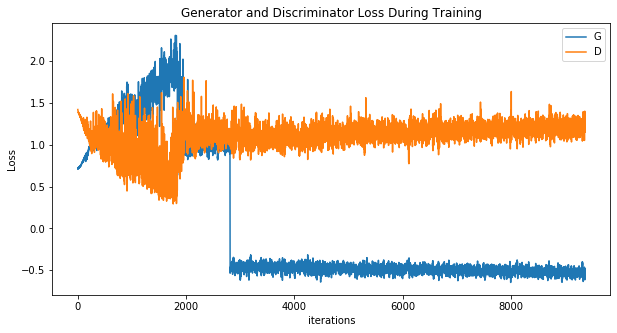

In [20]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

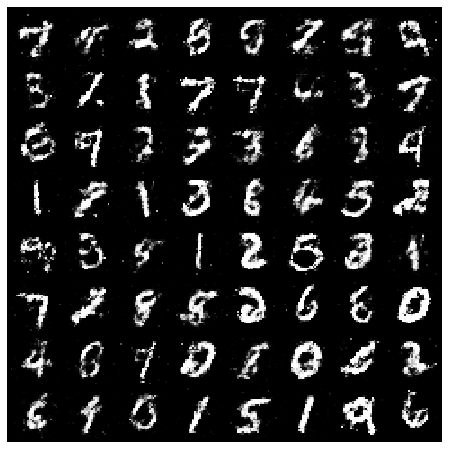

In [21]:
# Create slide show from fixed z images
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [
    [plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)]
    for i in fixed_img_list
]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Questions
1. Does making the generator more complex (adding layers) improve the generated images? Not for me
2. Does making the discriminator more complex or smarter force the generator to improve as well? Similar to previous question - not noticeably, at least in this case
3. Can you get the original generator loss function (i.e. log(1 - D(G(z)))) to work? Perhaps transition to it after some number of epochs. 
4. Bonus: Can you refactor the models to use convolution instead of fully connected layers?
Yes - see relevant section for 3/4. 

## Links
* [Link](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html): pytorch tutorial for DCGAN using a face dataset
* [Link](https://junyanz.github.io/CycleGAN/): the CycleGAN website